In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm_notebook as tqdm
import numpy as np
import sys 

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
epoch_train_loss = []
epoch_train_accuracy = []
def train( model, device, train_loader, optimizer, epoch):
    global log_interval
    model.train()
    pbar = tqdm(train_loader, file=sys.stdout)
    total_loss = 0
    batches = 0
    accuracy = 0
    n_examples = 0
    correct =0 
    for (data, target) in pbar:
        batches += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        n_examples += target.shape[0]
        loss = F.nll_loss(output, target)
        pbar.set_description("Loss: %.4f"%loss.item())
        pbar.update(1)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_train_loss.append(total_loss/batches)
    epoch_train_accuracy.append(correct/(n_examples*1.0))
#         if batch_idx % log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    n_examples = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            n_examples += target.shape[0]

    test_loss /= n_examples
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, n_examples,
        100. * correct / n_examples))

In [5]:
def collate_fn_task1(data):
    classes = [0,1,2,3,4]
    images, cl = zip(*data)
    images = torch.stack(images, 0)
    cl = torch.stack(cl, 0)
#     print(images.shape)
    final_images = []
    final_classes = []
    idx = []
    for i,c in enumerate(cl):
#         print(c.data)
        if c.data in classes:
            idx.append(i)
#     print(cl, idx)
    final_images = images[idx,:,:,:]
    final_classes = cl[idx]
#     print(final_classes)
    return (final_images, final_classes)

In [6]:
def collate_fn_task2(data):
    classes = [5,6,7,8,9]
    images, cl = zip(*data)
    images = torch.stack(images, 0)
    cl = torch.stack(cl, 0)
#     print(images.shape)
    final_images = []
    final_classes = []
    idx = []
    for i,c in enumerate(cl):
#         print(c.data)
        if c.data in classes:
            idx.append(i)
#     print(cl, idx)
    final_images = images[idx,:,:,:]
    final_classes = cl[idx]
#     print(final_classes)
    return (final_images, final_classes)

In [7]:
use_cuda = torch.cuda.is_available()

# torch.manual_seed(args.seed)
batch_size = 64
test_batch_size = 1000
log_interval = 100
lr = 0.01
momentum = 0.5
epochs = 10
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn_task1, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, collate_fn=collate_fn_task1, **kwargs)

In [8]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)



Test set: Average loss: 0.0405, Accuracy: 5067/5139 (99%)





Test set: Average loss: 0.0296, Accuracy: 5087/5139 (99%)





Test set: Average loss: 0.0216, Accuracy: 5097/5139 (99%)





Test set: Average loss: 0.0165, Accuracy: 5104/5139 (99%)





Test set: Average loss: 0.0135, Accuracy: 5112/5139 (99%)





Test set: Average loss: 0.0145, Accuracy: 5114/5139 (100%)





Test set: Average loss: 0.0108, Accuracy: 5119/5139 (100%)





Test set: Average loss: 0.0101, Accuracy: 5121/5139 (100%)





Test set: Average loss: 0.0108, Accuracy: 5121/5139 (100%)





Test set: Average loss: 0.0119, Accuracy: 5116/5139 (100%)



In [9]:
task1_train = epoch_train_accuracy
task1_loss = epoch_train_loss
epoch_train_accuracy = []
epoch_train_loss = []

# Task 2

In [10]:
#Setting training as Task 2
train_loader2 = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, collate_fn=collate_fn_task2, **kwargs)

# Setting test as Task 1
test_loader1 = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, collate_fn=collate_fn_task1, **kwargs)

test_loader2 = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, collate_fn=collate_fn_task2, **kwargs)

In [11]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader2, optimizer, epoch)
    test(model, device, test_loader1)
    test(model, device, test_loader2)



Test set: Average loss: 7.5736, Accuracy: 25/5139 (0%)


Test set: Average loss: 0.0858, Accuracy: 4720/4861 (97%)





Test set: Average loss: 8.2413, Accuracy: 1/5139 (0%)


Test set: Average loss: 0.0586, Accuracy: 4776/4861 (98%)





Test set: Average loss: 9.1383, Accuracy: 0/5139 (0%)


Test set: Average loss: 0.0436, Accuracy: 4794/4861 (99%)





Test set: Average loss: 8.8742, Accuracy: 0/5139 (0%)


Test set: Average loss: 0.0405, Accuracy: 4796/4861 (99%)





Test set: Average loss: 10.0186, Accuracy: 0/5139 (0%)


Test set: Average loss: 0.0390, Accuracy: 4805/4861 (99%)





Test set: Average loss: 9.9763, Accuracy: 0/5139 (0%)


Test set: Average loss: 0.0340, Accuracy: 4809/4861 (99%)





Test set: Average loss: 10.5614, Accuracy: 0/5139 (0%)


Test set: Average loss: 0.0349, Accuracy: 4807/4861 (99%)





Test set: Average loss: 11.0090, Accuracy: 0/5139 (0%)


Test set: Average loss: 0.0303, Accuracy: 4818/4861 (99%)





Test set: Average loss: 11.2231, Accuracy: 0/5139 (0%)


Test set: Average loss: 0.0304, Accuracy: 4812/4861 (99%)





Test set: Average loss: 11.0613, Accuracy: 0/5139 (0%)


Test set: Average loss: 0.0263, Accuracy: 4819/4861 (99%)



In [12]:
task2_train = epoch_train_accuracy
task2_loss = epoch_train_loss
epoch_train_accuracy = []
epoch_train_loss = []

# Retrain on Task 1

In [13]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader1)
    test(model, device, test_loader2)



Test set: Average loss: 0.0169, Accuracy: 5101/5139 (99%)


Test set: Average loss: 8.3146, Accuracy: 62/4861 (1%)





Test set: Average loss: 0.0126, Accuracy: 5115/5139 (100%)


Test set: Average loss: 9.5416, Accuracy: 17/4861 (0%)





Test set: Average loss: 0.0079, Accuracy: 5123/5139 (100%)


Test set: Average loss: 10.8523, Accuracy: 11/4861 (0%)





Test set: Average loss: 0.0088, Accuracy: 5124/5139 (100%)


Test set: Average loss: 12.0623, Accuracy: 2/4861 (0%)





Test set: Average loss: 0.0096, Accuracy: 5120/5139 (100%)


Test set: Average loss: 11.5450, Accuracy: 2/4861 (0%)





Test set: Average loss: 0.0067, Accuracy: 5128/5139 (100%)


Test set: Average loss: 11.1862, Accuracy: 3/4861 (0%)





Test set: Average loss: 0.0066, Accuracy: 5129/5139 (100%)


Test set: Average loss: 11.6763, Accuracy: 0/4861 (0%)





Test set: Average loss: 0.0064, Accuracy: 5127/5139 (100%)


Test set: Average loss: 13.0922, Accuracy: 0/4861 (0%)





Test set: Average loss: 0.0073, Accuracy: 5124/5139 (100%)


Test set: Average loss: 13.0570, Accuracy: 0/4861 (0%)





Test set: Average loss: 0.0067, Accuracy: 5128/5139 (100%)


Test set: Average loss: 12.4128, Accuracy: 3/4861 (0%)



In [14]:
retrain_task1_train = epoch_train_accuracy
retrain_task1_loss = epoch_train_loss
epoch_train_accuracy = []
epoch_train_loss = []

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
all_train_accuracy = np.array([task1_train, task2_train, retrain_task1_train]).flatten()
print(all_train_accuracy)

[0.86014512 0.96447248 0.97267617 0.97679435 0.97963786 0.98019349
 0.98212185 0.98362531 0.98418094 0.98503072 0.74789144 0.92436403
 0.94320501 0.95089104 0.95629846 0.96119576 0.96517481 0.9666712
 0.9693239  0.97143246 0.92773565 0.97123807 0.97875539 0.97980128
 0.98166427 0.98401752 0.9846712  0.98476925 0.98561904 0.98604393]


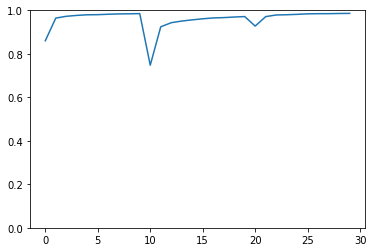

In [18]:
plt.ylim(0,1)
plt.plot(range(len(all_train_accuracy)), all_train_accuracy)

In [19]:
test_loader_all = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)
test(model, device, test_loader_all)


Test set: Average loss: 6.0373, Accuracy: 5131/10000 (51%)



In [20]:
test(model, device, test_loader1)


Test set: Average loss: 0.0067, Accuracy: 5128/5139 (100%)



In [21]:
test(model, device, test_loader2)


Test set: Average loss: 12.4128, Accuracy: 3/4861 (0%)

